In [ ]:
import numpy as np
import pandas as pd
import tensorflow
import torch
import tensorflow.keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Input,BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import AdamW

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir='/content/drive/MyDrive/Colab Notebooks/MERGED DATASET MALARIA'

In [ ]:
def generate_binary_labels():
    filepaths = []
    labels = []

    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)
        for fname in os.listdir(folder_path):
            filepaths.append(os.path.join(folder_path, fname))
            label = 1 if folder=="INFECTED" else 0
            labels.append(label)

    return filepaths, labels


In [ ]:
# Get filepaths and labels
filepaths, labels = generate_binary_labels()
filepaths = np.array(filepaths)
labels = np.array(labels)
print(filepaths.shape)
print(labels.shape)

(30984,)
(30984,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(filepaths, labels, test_size=0.2, stratify=labels)

In [ ]:
y_train = [str(label) for label in y_train]
y_val = [str(label) for label in y_val]

In [ ]:
image_size=(224,224)
batch_size=64

In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_train, 'class': y_train}),
    x_col='filename',
    y_col='class',
    target_size=image_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True
)

val_data = val_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_val, 'class': y_val}),
    x_col='filename',
    y_col='class',
    target_size=image_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)


Found 24787 validated image filenames belonging to 2 classes.
Found 6197 validated image filenames belonging to 2 classes.


In [ ]:
from sklearn.utils import class_weight, compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.0245949074074074), 1: np.float64(0.9765581908439052)}


In [ ]:
l1_l2_regularizer = regularizers.L1L2(l1=1e-6, l2=1e-5)

In [ ]:
base_model=VGG19(input_shape=(224,224,3),weights='imagenet',include_top=False)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Added top layers
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu',kernel_regularizer=l1_l2_regularizer)(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification output

In [ ]:
model = Model(inputs=base_model.input, outputs=x)

In [ ]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 False
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True
flatten_2 True
batch_normalization_2 True
dense_4 True
dropout_2 True
dense_5 True


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 23,336,257 (89.02 MB)

 Trainable params: 10,341,121 (39.45 MB)

 Non-trainable params: 12,995,136 (49.57 MB)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]


In [ ]:
model.compile(optimizer=AdamW(learning_rate=1e-5), loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
  2/388 ━━━━━━━━━━━━━━━━━━━━ 2:28 385ms/step - accuracy: 0.4805 - loss: 0.8624 

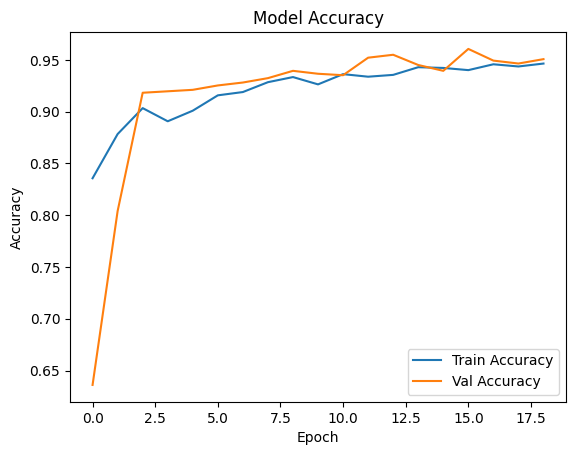

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

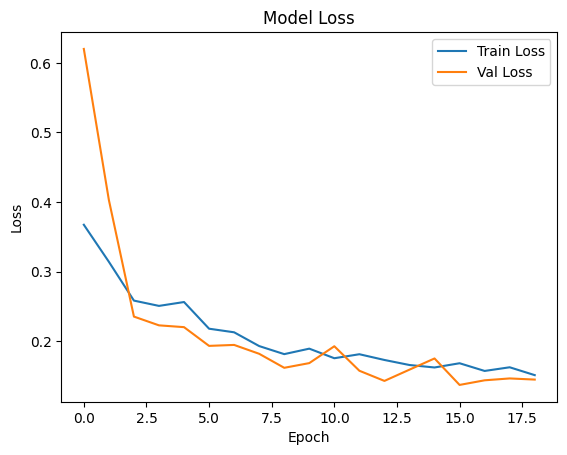

In [ ]:
# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step


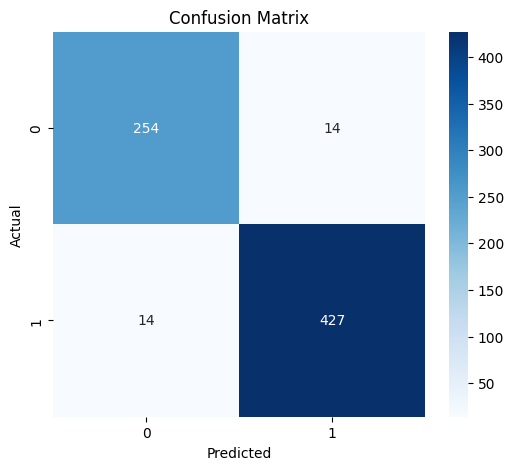

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       268
           1       0.97      0.97      0.97       441

    accuracy                           0.96       709
   macro avg       0.96      0.96      0.96       709
weighted avg       0.96      0.96      0.96       709



In [ ]:
import seaborn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on validation data
y_pred_probs = model.predict(val_data)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = val_data.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(val_data.class_indices.keys())

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))


In [ ]:
model.save('Malaria_model_final3.keras')